In [1]:
import gzip
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import eli5
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
with gzip.open('/Users/patrickdenning/Downloads/tokenised.jsl.gz', 'rb') as f:
    data = pd.read_json(f, lines=True)

In [3]:
text_entries = data["entry_text"]
labels = data["transaction"]

In [4]:
transactions = data.loc[data['transaction'] == True]
non_transactions = data.loc[data['transaction'] == False]

In [5]:
non_transactions_sampled = non_transactions.sample(frac=0.1, random_state=42)

In [7]:
bootstrapped_data = pd.concat([transactions, non_transactions_sampled], axis=0).sample(frac=1).reset_index(drop=True)

In [8]:
vectorizer = TfidfVectorizer()

In [9]:
text_entries = bootstrapped_data["entry_text"]
labels = bootstrapped_data["transaction"]

In [10]:
feature_vectors = vectorizer.fit_transform(text_entries)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, labels, test_size=0.33, random_state=42)


In [12]:
# Show that bootstrapping has rebalanced data
pd.value_counts(y_train)

False    34157
True     26115
Name: transaction, dtype: int64

In [13]:
# Train a logistic regression classifier on the bootstrapped data
lgr_classifier = LogisticRegression(max_iter=1000)

In [14]:
lgr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [15]:
lgr_test_predictions = lgr_classifier.predict(X_test)

In [16]:

print(metrics.classification_report(y_test, lgr_test_predictions))


              precision    recall  f1-score   support

       False       0.91      0.91      0.91     16781
        True       0.88      0.89      0.88     12906

    accuracy                           0.90     29687
   macro avg       0.90      0.90      0.90     29687
weighted avg       0.90      0.90      0.90     29687



In [17]:
# Train a naive Bayes classifier on the bootstrapped data
nb_classifier = MultinomialNB()

In [18]:
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [19]:
nb_test_preditions = nb_classifier.predict(X_test)

In [20]:
print(metrics.classification_report(y_test, nb_test_preditions))

              precision    recall  f1-score   support

       False       0.87      0.89      0.88     16781
        True       0.85      0.82      0.83     12906

    accuracy                           0.86     29687
   macro avg       0.86      0.85      0.85     29687
weighted avg       0.86      0.86      0.86     29687



In [21]:
all_text_entries = data["entry_text"]
all_labels = data["transaction"]

In [22]:
X_all = vectorizer.transform(all_text_entries)

In [24]:
# Get the logistic regression classifier's predictions for the entire dataset (i.e. before resampling)
lgr_all_predictions = lgr_classifier.predict(X_all)

In [25]:
print(metrics.classification_report(all_labels, lgr_all_predictions))

              precision    recall  f1-score   support

       False       0.99      0.90      0.94    509382
        True       0.41      0.91      0.57     39021

    accuracy                           0.90    548403
   macro avg       0.70      0.91      0.76    548403
weighted avg       0.95      0.90      0.92    548403



In [26]:
# Look at lgr model's weights
eli5.show_weights(lgr_classifier, vec=vectorizer, top=50, target_names=['True', 'False'])


Weight?,Feature
+10.801,x262957
+9.173,x133112
+8.624,x251443
+6.947,x317359
+6.812,x130827
+6.438,x271285
+6.117,x30196
+6.107,x166454
+5.971,x30178
+5.906,x251440


In [29]:
lgr_all_confidence_scores = lgr_classifier.decision_function(X_all)

array([-1.39346872, -0.73214262, -1.31571595, ...,  1.44986305,
        1.85270637,  3.01256896])

In [30]:
precisions, recalls, thresholds = precision_recall_curve(all_labels, lgr_all_confidence_scores)

521575 521574


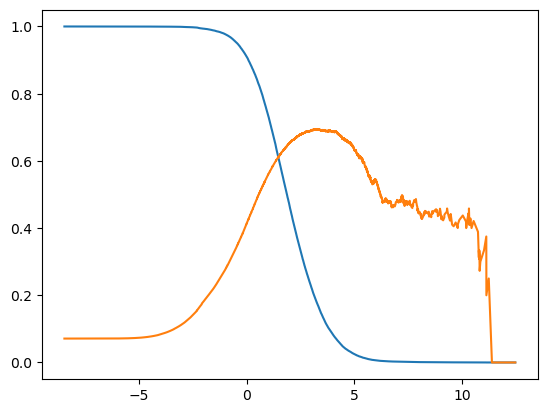

In [59]:
# Visualise precision and recall tradeoff at different decision thresholds
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.show()

In [34]:
# Print threshold that maximises recall
max_recall_threshold = thresholds[np.argmax(recalls)]
print("Threshold that maximizes recall: {:.3f}".format(max_recall_threshold))


521575 521575 521574
Threshold that maximizes recall: -8.448


In [64]:
# Find a reasonable custom threshold to tradeoff in favour of recall

mask = (precisions > 0.2)

filtered_recalls = recalls[mask]
filtered_thresholds = thresholds[:-1][mask]

max_recall_index = np.argmax(filtered_recalls)

max_recall_threshold = filtered_thresholds[max_recall_index]

print("Threshold that maximizes recall while keeping precision above 0.2: {:.3f}".format(max_recall_threshold))

521573 521573 521574
521573 521573 521574
[False False False ...  True False False]
(521573,)
(521573,)
(521574,)
0.0
0.0
Threshold that maximizes recall while keeping precision above 0.2: -1.773


In [67]:
# Show the metrics using the custom threshold

lgr_custom_threshold_predictions = (lgr_all_confidence_scores >= max_recall_threshold).astype(int)

print(metrics.classification_report(all_labels, lgr_custom_threshold_predictions))

              precision    recall  f1-score   support

       False       1.00      0.70      0.82    509382
        True       0.20      0.99      0.33     39021

    accuracy                           0.72    548403
   macro avg       0.60      0.84      0.58    548403
weighted avg       0.94      0.72      0.79    548403



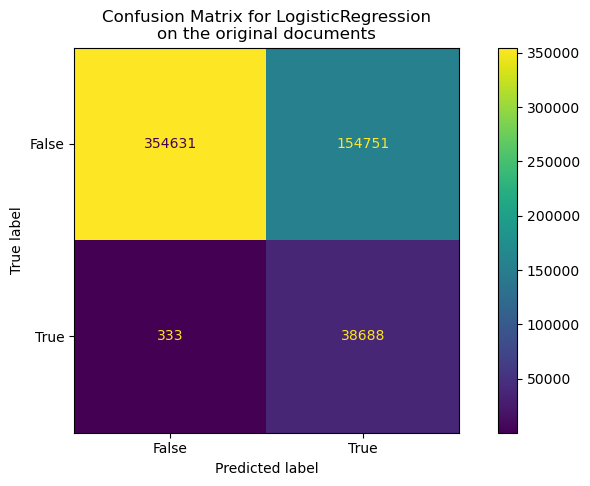

In [66]:
# Visualise predictions using a confusion matrix

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(all_labels, lgr_custom_threshold_predictions, ax=ax)
ax.xaxis.set_ticklabels([False,  True])
ax.yaxis.set_ticklabels([False,  True])
_ = ax.set_title(
    f"Confusion Matrix for {lgr_classifier.__class__.__name__}\non the original documents"
)